# Feature engineering
------------------------------

This example shows how to use automated feature generation to improve your model's performance.

The data used is a variation on the Australian weather dataset from [https://www.kaggle.com/jsphyg/weather-dataset-rattle-package](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package). The goal of this dataset is to predict whether or not it will rain tomorrow training a binay classifier on target `RainTomorrow`.

## Load the data

In [1]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

In [2]:
# Load data
X = pd.read_csv('./datasets/weatherAUS.csv')

# Let's have a look at a subset of the data
X.sample(frac=1).iloc[:5, :8]

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed
118244,Perth,20.9,35.5,0.0,11.0,13.1,SW,31.0
17985,NorahHead,19.1,21.0,0.0,NaN,NaN,S,44.0
96569,Adelaide,7.6,16.1,1.8,NaN,NaN,SW,35.0
63982,MelbourneAirport,5.8,11.9,3.6,1.8,6.6,N,52.0
97093,MountGambier,6.2,11.7,10.8,1.8,0.8,WNW,31.0


## Run the pipeline

In [3]:
# Initiate ATOM and apply data cleaning
atom = ATOMClassifier(X, n_rows=1e4, test_size=0.2, verbose=0, random_state=1)
atom.impute(strat_num='knn', strat_cat='remove', min_frac_rows=0.8)
atom.encode(max_onehot=10, frac_to_other=0.04)

# Let's see how a LightGBM model performs without adding additional features
atom.run('LGB', metric='auc')
atom.scoring()

Results ===================== >>
LightGBM --> roc_auc: 0.945


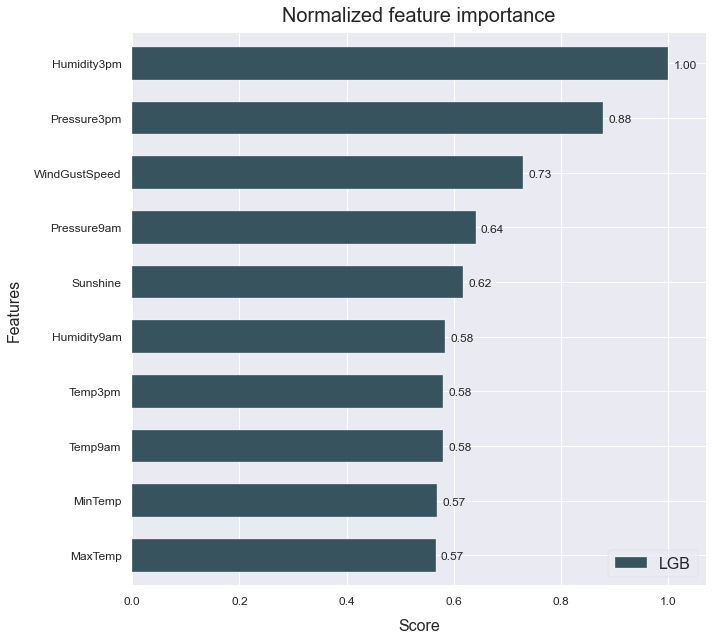

In [4]:
# What are the most important fetaures?
atom.plot_feature_importance(show=10)

**Now let's create some new fetaures using Deep Feature Synthesis**

In [5]:
atom.verbose = 2  # Increase verbosity to see the output

# Create 100 new features using DFS
atom.feature_generation(strategy='dfs', n_features=100)

# Select the best 50 features using RFECV
atom.feature_selection(strategy='RFECV', solver='lgb', n_features=30, scoring='auc')

Fitting FeatureGenerator...
Creating new features...
 --> 100 new features were added to the dataset.
Fitting FeatureSelector...


C:\Users\Mavs\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing feature selection ...
 --> Feature Location was removed due to low variance. Value 0.21025 repeated in 100.0% of rows.
 --> Feature WindDir3pm + WindSpeed9am was removed due to collinearity with another feature.
 --> Feature Pressure9am + RainToday_Yes was removed due to collinearity with another feature.
 --> Feature Cloud9am + Humidity9am was removed due to collinearity with another feature.
 --> Feature MaxTemp + WindGustDir was removed due to collinearity with another feature.
 --> Feature Location + Pressure3pm was removed due to collinearity with another feature.
 --> Feature Location + Rainfall was removed due to collinearity with another feature.
 --> Feature RainToday_Yes + Temp9am was removed due to collinearity with another feature.
 --> Feature Evaporation + Location was removed due to collinearity with another feature.
 --> Feature Location + MaxTemp was removed due to collinearity with another feature.
 --> Feature Location - RainToday_Yes was removed due to co

In [6]:
# The collineart attribute shows what features
# were removed due to collinearity
atom.collinear

,drop_feature,correlated_feature,correlation_value
0,WindDir3pm + WindSpeed9am,WindSpeed9am,0.99999
1,Pressure9am + RainToday_Yes,Pressure9am,0.99832
2,Cloud9am + Humidity9am,Humidity9am,0.99422
3,MaxTemp + WindGustDir,MaxTemp,0.99998
4,Location + Pressure3pm,Pressure3pm,1.0
5,Location + Rainfall,Rainfall,1.0
6,RainToday_Yes + Temp9am,Temp9am,0.99794
7,Evaporation + Location,Evaporation,1.0
8,Location + MaxTemp,"MaxTemp, MaxTemp + WindGustDir","1.0, 0.99998"
9,Location - RainToday_Yes,"RainToday_Yes, RainToday_No","-1.0, 0.98441"


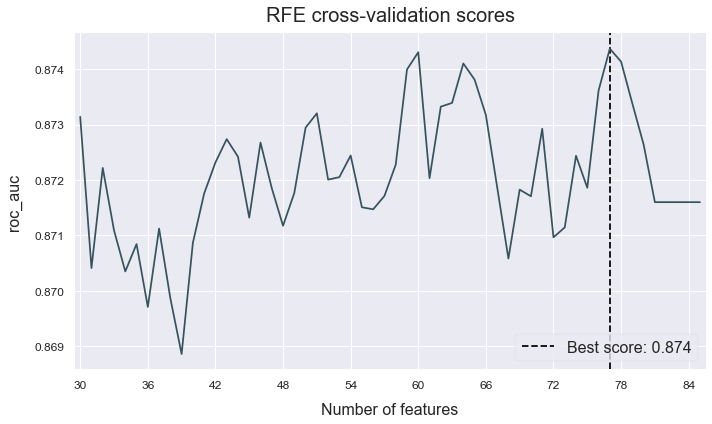

In [7]:
# After applying RFECV, we can plot the score per number of features
atom.plot_rfecv()

In [8]:
# Since the new features apply divisions, we can have inf values in the dataset
atom.impute(strat_num='knn', strat_cat='remove', min_frac_rows=0.8)

Fitting Imputer...
Imputing missing values...
 --> Imputing 4 missing values using the KNN imputer in feature Temp9am / MinTemp.
 --> Dropping feature WindSpeed3pm / Rainfall for containing 5766 (64%) missing values.
 --> Imputing 33 missing values using the KNN imputer in feature Evaporation / WindSpeed3pm.
 --> Imputing 17 missing values using the KNN imputer in feature RainToday_No / Evaporation.
 --> Imputing 4 missing values using the KNN imputer in feature Cloud9am / MinTemp.
 --> Imputing 290 missing values using the KNN imputer in feature Pressure9am / Cloud3pm.
 --> Imputing 33 missing values using the KNN imputer in feature Pressure9am / WindSpeed3pm.
 --> Imputing 17 missing values using the KNN imputer in feature MinTemp / Evaporation.
 --> Imputing 4 missing values using the KNN imputer in feature Cloud3pm / MinTemp.
 --> Imputing 4 missing values using the KNN imputer in feature Rainfall / MinTemp.
 --> Imputing 17 missing values using the KNN imputer in feature WindSpeed

In [9]:
# Let's see how the model performs now
atom.run('LGB')


Running pipeline ============================= >>
Models in pipeline: LGB
Metric: roc_auc


Results for LightGBM:         
Fitting -----------------------------------------
Score on the train set --> roc_auc: 0.9955
Score on the test set  --> roc_auc: 0.9502
Time elapsed: 1.409s
-------------------------------------------------
Total time: 1.428s


Final results ========================= >>
Duration: 1.430s
------------------------------------------
LightGBM --> roc_auc: 0.950


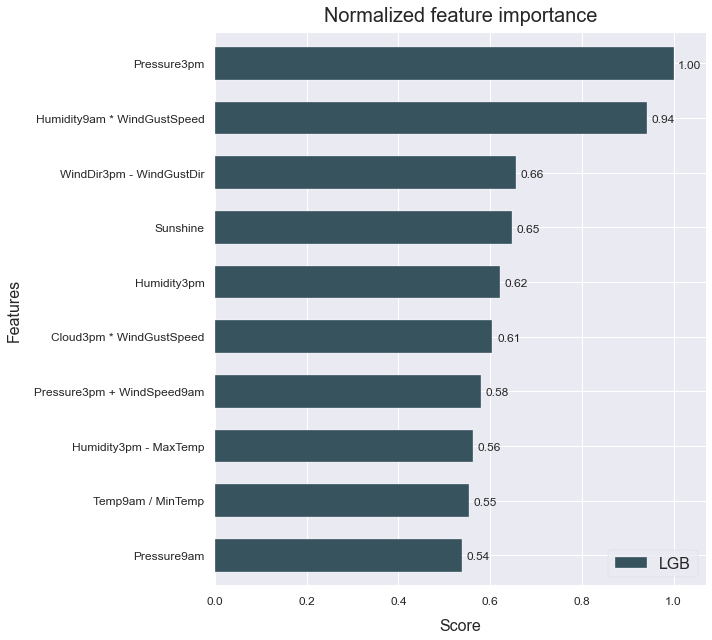

In [10]:
# Did the feature importance change?
atom.plot_feature_importance(show=10)

**Lets try the same using Genetic Feature Generation**

In [11]:
atom = ATOMClassifier(X, n_rows=1e4, test_size=0.2, verbose=0, random_state=1)
atom.impute(strat_num='knn', strat_cat='remove', min_frac_rows=0.8)
atom.encode(max_onehot=10, frac_to_other=0.04)

atom.verbose = 2  # Increase verbosity to see the steps

# Create new features using Genetic Programming
atom.feature_generation(strategy='genetic', n_features=10, generations=20, population=1000)

Fitting FeatureGenerator...
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     3.13         0.135435        3         0.503097              N/A     11.11s
   1     3.18         0.348074        7         0.506413              N/A     10.95s
   2     3.23         0.437331        5         0.513643              N/A      9.99s
   3     3.44         0.457825        5         0.513643              N/A      9.33s
   4     4.50         0.449698        9         0.522278              N/A      8.81s
   5     5.65          0.45053       13         0.527538              N/A      9.66s
   6     7.76         0.472921       17         0.528579              N/A      7.96s
   7     9.36          0.49098       15         0.529782              N/A      7.43s
   8     9.83         0.488757       15        

In [12]:
# We can see the feature's fitness and description through the genetic_features attribute
atom.genetic_features

,name,description,fitness
0,Feature 23,"mul(Humidity3pm, mul(add(WindGustSpeed, WindDi...",0.542663
1,Feature 24,"mul(sub(add(WindGustSpeed, WindDir9am), Sunshi...",0.539049
2,Feature 25,"mul(Humidity3pm, mul(sub(Humidity3pm, Sunshine...",0.533669
3,Feature 26,"mul(Humidity3pm, mul(Humidity3pm, mul(Humidity...",0.530592
4,Feature 27,"mul(Humidity3pm, mul(Humidity3pm, add(WindGust...",0.532912
5,Feature 28,"mul(sub(sub(add(WindGustSpeed, WindDir9am), Su...",0.522363
6,Feature 29,"mul(Humidity3pm, mul(Humidity3pm, sub(sub(sub(...",0.518317
7,Feature 30,"mul(mul(Humidity3pm, sub(sub(add(WindGustSpeed...",0.511776
8,Feature 31,"mul(Humidity3pm, mul(Humidity3pm, mul(Humidity...",0.514151
9,Feature 32,"mul(Humidity3pm, mul(Humidity3pm, sub(sub(sub(...",0.516328


In [13]:
# And fit the model again
atom.run('LGB', metric='auc')


Running pipeline ============================= >>
Models in pipeline: LGB
Metric: roc_auc


Results for LightGBM:         
Fitting -----------------------------------------
Score on the train set --> roc_auc: 0.9879
Score on the test set  --> roc_auc: 0.9459
Time elapsed: 0.545s
-------------------------------------------------
Total time: 0.557s


Final results ========================= >>
Duration: 0.559s
------------------------------------------
LightGBM --> roc_auc: 0.946


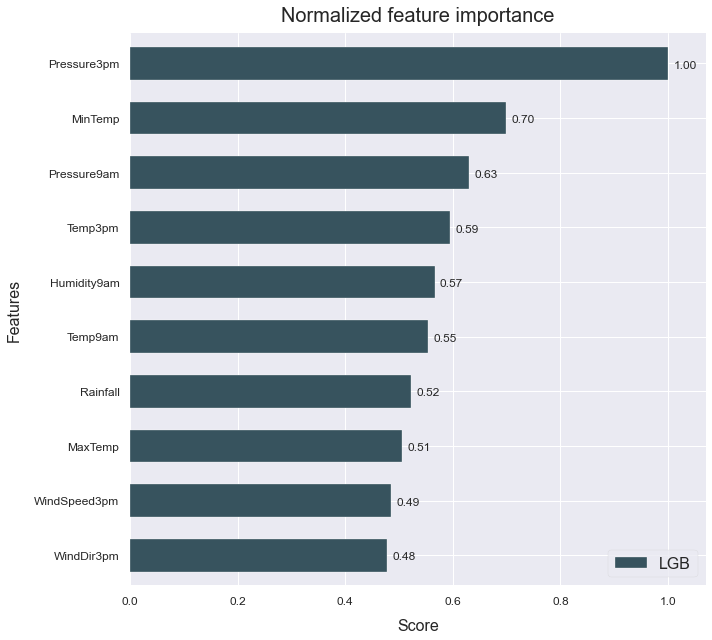

In [14]:
# And show the feature importance
atom.plot_feature_importance(show=10)